In [1]:
import json
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

train_root_path = '/hpi/fs00/share/fg/rabl/strassenburg/datasets/coco/train2017'
train_annotations = '/hpi/fs00/share/fg/rabl/strassenburg/datasets/coco/annotations/instances_train2017.json'

val_root_path = '/hpi/fs00/share/fg/rabl/strassenburg/datasets/coco/val2017'
val_annotations = '/hpi/fs00/share/fg/rabl/strassenburg/datasets/coco/annotations/instances_val2017.json'

In [2]:
%matplotlib inline

In [3]:
def id_to_class_index(annotations_path):
    index = {}
    with open(annotations_path, 'r') as COCO:
        js = json.loads(COCO.read())
        cats = js['categories']

        for cat in cats:
            index[cat['id']] = cat['name']

    return index


In [4]:
train_cat_index = id_to_class_index(train_annotations)
val_cat_index = id_to_class_index(val_annotations)

In [5]:
print(len(train_cat_index))
print(len(val_cat_index))

print(val_cat_index == train_cat_index)

80
80
True


In [6]:
print('all categories')
print(train_cat_index.values())

all categories
dict_values(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])


In [7]:
train_coco_data = torchvision.datasets.CocoDetection(train_root_path, train_annotations)
val_coco_data = torchvision.datasets.CocoDetection(val_root_path, val_annotations)

loading annotations into memory...
Done (t=11.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [8]:
def category_ids(annotation):
    cat_ids = set()
    for a in annotation:
        cat_ids.add(a['category_id'])

    return cat_ids


def filter_number_of_categories(elements, num_categories):
    return [e for e in elements if len(category_ids(e[1])) <= num_categories]



In [9]:
print('val set')
val_three_cats = filter_number_of_categories(val_coco_data, 3)
print('num pictures with max 3 categories: {}'.format(len(val_three_cats)))
val_two_cats = filter_number_of_categories(val_three_cats, 2)
print('num pictures with max 2 categories: {}'.format(len(val_two_cats)))
val_one_cat = filter_number_of_categories(val_two_cats, 1)
print('num pictures with max 1 categories: {}'.format(len(val_one_cat)))




val set
num pictures with max 3 categories: 3575
num pictures with max 2 categories: 2595
num pictures with max 1 categories: 1073


In [18]:
print('train set')
train_three_cats = filter_number_of_categories(train_coco_data, 3)
print('num pictures with 3 categories: {}'.format(len(train_three_cats)))
train_two_cats = filter_number_of_categories(train_three_cats, 2)
print('num pictures with 2 categories: {}'.format(len(train_two_cats)))
train_one_cat = filter_number_of_categories(train_two_cats, 1)
print('num pictures with 1 categories: {}'.format(len(train_one_cat)))

# print instead of execute to save time
print("train set \nnum pictures with 3 categories: 85234 \nnum pictures with 2 categories: 61065 \nnum pictures with 1 categories: 25207")


train set
num pictures with 3 categories: 85234
num pictures with 2 categories: 61065
num pictures with 1 categories: 25207
train set 
num pictures with 3 categories: 85234 
num pictures with 2 categories: 61065 
num pictures with 1 categories: 25207


In [11]:
def show_image(element):
    img, annot = element
    all_cats = category_ids(annot)
    all_cats = set(map(lambda x: train_cat_index[x], all_cats))
    print('annotations set:\n {}'.format(all_cats))
    imshow(np.asarray(img))

annotations set:
 {'person', 'clock', 'cell phone'}


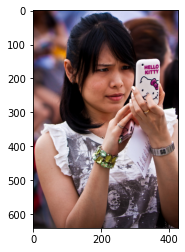

In [12]:
show_image(val_three_cats[7])

annotations set:
 {'person', 'tennis racket'}


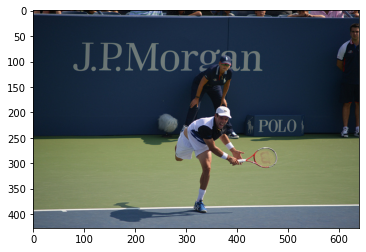

In [13]:
show_image(val_two_cats[4])

annotations set:
 {'bear'}


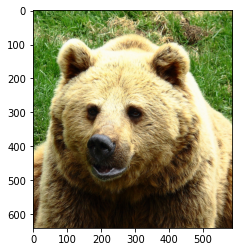

In [14]:
show_image(val_one_cat[0])

annotations set:
 {'zebra'}


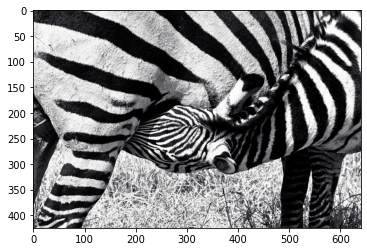

In [15]:
show_image(val_one_cat[1])


In [68]:
def update_distribution(cat, dis):
    if cat in dis:
        dis[cat] += 1
    else:
        dis[cat] = 1

def cat_distribution(data):
    cat_dis = {}
    for d in data:
        _, annot = d
        cat_list = list(category_ids(annot))
        if len(cat_list):
            cat = list(category_ids(annot))[0]
            cat = train_cat_index[cat]
        else:
            cat = 'NO CAT'
        update_distribution(cat, cat_dis)
    return cat_dis

def get_top_cat_count(data, limit):
    cat_dist = cat_distribution(data)
    sorted_dist = {k: v for k, v in sorted(cat_dist.items(), key=lambda item: item[1], reverse=True)}
    top_cat = list(sorted_dist.keys())[:limit]
    top_counts = list(sorted_dist.values())[:limit]
    return top_cat, top_counts

def plot_one_cat_distribution(data, limit=20):
    top_cats, top_counts = get_top_cat_count(data, limit)

    fig, ax = plt.subplots()
    bar_plot = plt.bar(top_cats, top_counts)
    fig.set_size_inches(18.5, 8)
    plt.xticks(rotation=65)
    plt.show()

def print_data(data):
    for d in data:
        print(d)

def print_key_value(keys, values):
    for i in range(len(keys)):
        print('{}: {}'.format(keys[i],values[i]))

Validation set: Category distribution over all pictures with only one assigned category


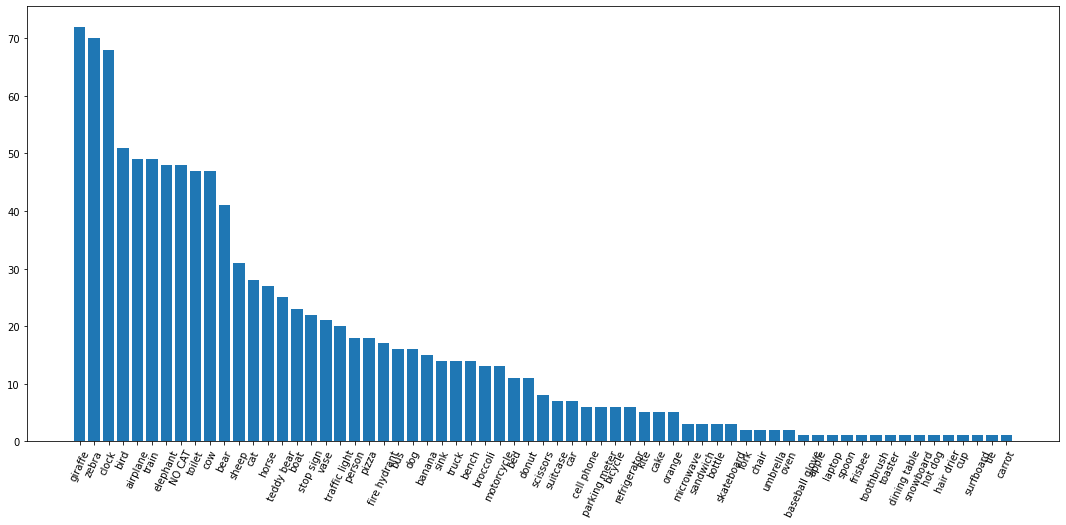

In [69]:
print('Validation set: Category distribution over all pictures with only one assigned category')
plot_one_cat_distribution(val_one_cat, 70)

In [70]:
top_val_cats, top_val_counts = get_top_cat_count(val_one_cat, 100)
print('Validation set: List of categories only one assigned category')
print_key_value(top_val_cats, top_val_counts)

Validation set: List of categories only one assigned category
giraffe: 72
zebra: 70
clock: 68
bird: 51
airplane: 49
train: 49
elephant: 48
NO CAT: 48
toilet: 47
cow: 47
bear: 41
sheep: 31
cat: 28
horse: 27
teddy bear: 25
boat: 23
stop sign: 22
vase: 21
traffic light: 20
person: 18
pizza: 18
fire hydrant: 17
bus: 16
dog: 16
banana: 15
sink: 14
truck: 14
bench: 14
broccoli: 13
motorcycle: 13
bed: 11
donut: 11
scissors: 8
suitcase: 7
car: 7
cell phone: 6
parking meter: 6
bicycle: 6
refrigerator: 6
kite: 5
cake: 5
orange: 5
microwave: 3
sandwich: 3
bottle: 3
skateboard: 3
fork: 2
chair: 2
umbrella: 2
oven: 2
baseball glove: 1
apple: 1
laptop: 1
spoon: 1
frisbee: 1
toothbrush: 1
toaster: 1
dining table: 1
snowboard: 1
hot dog: 1
hair drier: 1
cup: 1
surfboard: 1
tie: 1
carrot: 1


Training set: Category distribution over all pictures with only one assigned category


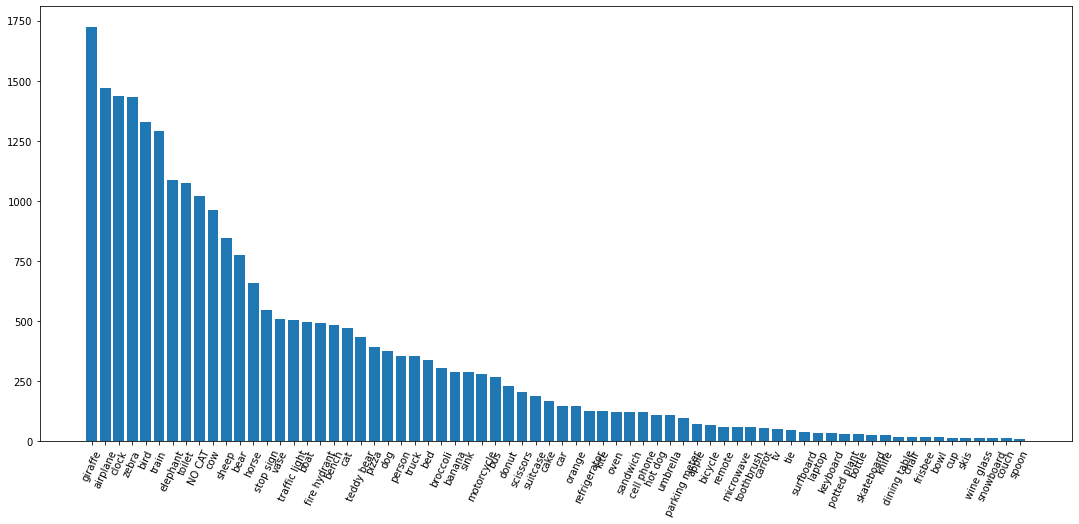

In [71]:
print('Training set: Category distribution over all pictures with only one assigned category')
plot_one_cat_distribution(train_one_cat, limit=70)

In [72]:
top_train_cats, top_train_counts = get_top_cat_count(train_one_cat, 100)
print('Training set: List of categories only one assigned category')
print_key_value(top_train_cats, top_train_counts)

Training set: List of categories only one assigned category
giraffe: 1723
airplane: 1470
clock: 1436
zebra: 1432
bird: 1330
train: 1291
elephant: 1089
toilet: 1075
NO CAT: 1021
cow: 962
sheep: 847
bear: 776
horse: 658
stop sign: 546
vase: 509
traffic light: 506
boat: 496
fire hydrant: 492
bench: 483
cat: 471
teddy bear: 434
pizza: 393
dog: 374
person: 354
truck: 353
bed: 337
broccoli: 304
banana: 289
sink: 287
motorcycle: 280
bus: 266
donut: 232
scissors: 206
suitcase: 187
cake: 167
car: 149
orange: 149
refrigerator: 125
kite: 125
oven: 124
sandwich: 123
cell phone: 120
hot dog: 110
umbrella: 109
parking meter: 97
apple: 71
bicycle: 68
remote: 60
microwave: 59
toothbrush: 58
carrot: 56
tv: 50
tie: 48
surfboard: 40
laptop: 33
keyboard: 33
potted plant: 30
bottle: 29
skateboard: 28
knife: 28
dining table: 20
chair: 20
frisbee: 19
bowl: 19
cup: 15
skis: 14
wine glass: 13
snowboard: 13
couch: 12
spoon: 9
toaster: 8
baseball bat: 8
mouse: 7
sports ball: 6
tennis racket: 6
handbag: 5
book: 5

In [73]:
img_root_path = '/hpi/fs00/share/fg/rabl/strassenburg/datasets/imgnet'
imagenet_data = torchvision.datasets.ImageNet(img_root_path, split='val')

In [104]:
img_classes = set()
for cls in imagenet_data.classes:
    for c in cls:
        img_classes.add(c)

coco_classes = set(train_cat_index.values())

common_classes = coco_classes.intersection(img_classes)

print('list of classes that exactly match with imagenet data')
for cls in common_classes:
    print(cls)

list of classes that exactly match with imagenet data
teddy bear
cup
umbrella
kite
refrigerator
zebra
mouse
banana
microwave
parking meter
pizza
toaster
laptop
hot dog
orange
traffic light
remote
dining table
hair drier
vase
broccoli
backpack


In [109]:
def get_common_categories(distribution, common_set):
    cats = set(distribution.keys())
    return list(cats.intersection(common_set))

In [111]:
one_train_cat_dist = cat_distribution(train_one_cat)
two_train_cat_dist = cat_distribution(train_two_cats)
three_train_cat_dist = cat_distribution(train_three_cats)

one_common = get_common_categories(one_train_cat_dist ,common_classes)
two_common = get_common_categories(two_train_cat_dist ,common_classes)
three_common = get_common_categories(three_train_cat_dist ,common_classes)

In [112]:
def print_classes(classes, index):
    classes = sorted(classes, key= lambda x: index[x], reverse=True)
    sum = 0
    for cls in classes:
        count = index[cls]
        print('{}: {}'.format(cls, count))
        sum += count
    print('################# SUM: {}'.format(sum))

print('only one cat')
print_classes(one_common, one_train_cat_dist)
print('\n\n\nmax two cat')
print_classes(two_common, two_train_cat_dist)
print('\n\n\nmax three cat')
print_classes(three_common, three_train_cat_dist)

only one cat
zebra: 1432
vase: 509
traffic light: 506
teddy bear: 434
pizza: 393
broccoli: 304
banana: 289
orange: 149
kite: 125
refrigerator: 125
hot dog: 110
umbrella: 109
parking meter: 97
remote: 60
microwave: 59
laptop: 33
dining table: 20
cup: 15
toaster: 8
mouse: 7
hair drier: 3
backpack: 2
################# SUM: 4789



max two cat
zebra: 1743
traffic light: 1063
teddy bear: 1057
broccoli: 763
pizza: 591
vase: 569
dining table: 502
banana: 453
laptop: 301
refrigerator: 291
hot dog: 232
umbrella: 179
orange: 151
kite: 127
remote: 112
parking meter: 101
mouse: 88
microwave: 88
hair drier: 39
backpack: 25
cup: 23
toaster: 18
################# SUM: 8516



max three cat
zebra: 1812
teddy bear: 1482
traffic light: 1220
broccoli: 1151
dining table: 929
laptop: 786
pizza: 700
vase: 623
banana: 539
backpack: 436
refrigerator: 409
hot dog: 319
umbrella: 189
kite: 176
orange: 153
remote: 141
mouse: 134
parking meter: 101
hair drier: 99
microwave: 93
toaster: 32
cup: 29
################# 

In [113]:
print('check if any of the elements matches multiple imagenet categories')
# count = 0
# for e in train_two_cats:
#     img, annot = e
#     cat_ids = list(category_ids(annot))
#     cats = set(map(lambda x: train_cat_index[x], cat_ids))
#     common = cats.intersection(img_classes)
#     if len(common) >= 2:
#         print(common)
#         count += 1
#
# print(count)







check if any of the elements matches multiple imagenet categories
